# twitter description analysis

## twitterのdescriptionとは?

以下の画像のように、ユーザの自己紹介文のことです。
![](https://github.com/plue1011/NetworkAnalysis/blob/master/Image/description_example.png?raw=true)

## データの取得方法

twitter APIを使用して、以下のようにuser networkを取得します。

0-3は、twitter.ipynbにて実装しています。

0. root userのdescriptionをmecabで分かち書きして、list化する
1. root userのフォロワー(:=neighbor user)を取得
2. neighbor userのうち、共通のdescription wordを持つuserのフォロワーを取得
3. 2を複数回行う
4. 0-3から得られるネットワークのadjacency listをadj_list.pklとして保存
5. adjacency listに含まれるuserの情報をusers_info.pklとして保存

## ライブラリの読み込み

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
import japanize_matplotlib
from sklearn.preprocessing import LabelEncoder

import sys
sys.path.append('../')
from twitter import GetDescriptionNetwork
from twitter import CleansingTweets
from tokenizer import Tokenizer
from influence import InfuenceMaximizer as im

/Users/fuekimasao/.pyenv/versions/anaconda3-2020.02/envs/network/lib/python3.8/site-packages/japanize_matplotlib/japanize_matplotlib.py:15: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


## データの読み込み

手順4,5で保存しているデータを読み出します。

In [2]:
# userの情報を読み出す
user_info = pickle.load(open('./data/users_info.pkl', 'rb'))

In [3]:
# 枝確率を計算済みのネットワークを読み込む
network = pd.read_pickle("./data/adj_list.pkl")
network_np = network.values
network.head()

,from_node,to_node,p
0,kotapudding,kitty_zr20bz,0.001087
1,kotapudding,ik2020oil,0.008696
2,kotapudding,knknknk29,0.021739
3,kotapudding,FlyingTiger_JP,0.000144
4,kotapudding,Posse_ss4,0.001024


※ ここで、p列は、from_node -> to_nodeへ情報が伝播する確率が格納されています。

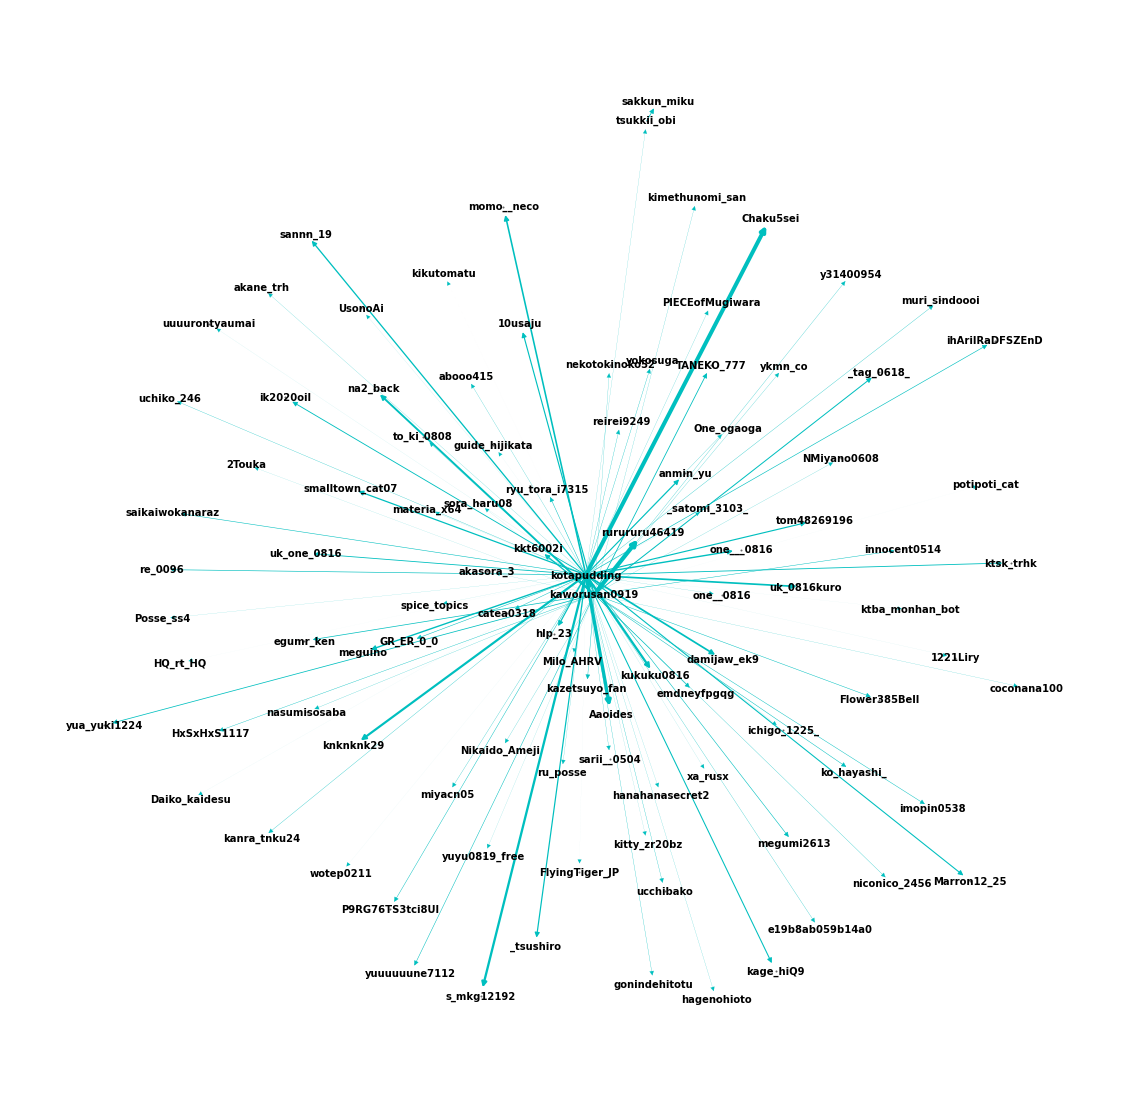

In [4]:
G = nx.DiGraph()
G.add_weighted_edges_from(network_np[:100, :])

plt.figure(figsize=(20, 20))
plt.axis('off')
pos = nx.spring_layout(G, k=0.01)
nx.draw_networkx_nodes(G, pos, node_color="w", alpha=0.6, node_size=1, edgecolors="k")
nx.draw_networkx_labels(G, pos, font_size=10, font_weight="bold")
nx.draw_networkx_edges(G, pos, edge_color="c", 
                       width=np.array(list(nx.get_edge_attributes(G, 'weight').values()))*100)
plt.show()

※ 見えやすいように、100本の枝のみを描画しています。

試しに、userの情報を見てみます。

In [5]:
user = network['from_node'][0]
user_info[user]

{'id': 2172506029,
 'screen_name': 'kotapudding',
 'location': '',
 'url': None,
 'description': '中身のないことを常に考えている成人済オタ。月島蛍のATM。ハイキュー＊月島/文スト＊芥川/サイコパス＊宜野座/i7＊一織/YOI＊ユリオ/氷菓/Free!＊郁弥。うちやまこうきさんとますだとしきさん。\n無言フォローしがちです、すみません！',
 'description_clean': '中身のないことを常に考えている成人済オタ。月島蛍のatm。ハイキュー*月島/文スト*芥川/サイコパス*宜野座/i0*一織/yoi*ユリオ/氷菓/free!*郁弥。うちやまこうきさんとますだとしきさん。無言フォローしがちです、すみません!',
 'followers_count': 65,
 'friends_count': 279,
 'listed_count': 0,
 'favourites_count': 13707,
 'statuses_count': 24217,
 'created_at': datetime.datetime(2013, 11, 3, 17, 19, 2),
 'elapsed_date': 2492,
 'favorite_per_day': 5.50040128410915,
 'tweet_per_day': 9.717897271268058}

## descriptionの単語集合

上記のuserのdescriptionを分かち書きします。以下では、`gn`というインスタンスを作成していますが、`GetDescriptionNetwork`クラスに、twitterのdescription用のstopwordsが格納されているためです。  
また、`GetDescriptionNetwork`クラスのメソッドの`tokenizer`によって、クレンジング済みのdescriptionを分かち書きしています。  
この分かち書きされた単語集合から、先ほどのdescription用のstopwordsを消すことで、descriptionの単語集合を作成しています。

In [6]:
gn = GetDescriptionNetwork(cleansing=CleansingTweets().cleansing_text, tokenizer=Tokenizer().mecab_tokenizer)
network_keywords = list(set(gn.tokenizer(user_info[user]['description_clean'])) - set(gn.description_stopwords))
print(network_keywords)

['郁弥', 'yoi', 'ハイキュー!!', '中身', '月島蛍', 'しき', 'こうき', '氷菓', 'PSYCHO-PASS', '考える', 'ユリオ', 'スト', '月島', 'atm', 'ます', '宜野座', '一織', 'Free!', 'オタ', 'i', '芥川']


root userと共通している単語を`link_info`に格納し、共通している単語数を`link_size`に格納します。

In [7]:
network['link_info']= network.apply(
    lambda x: set(gn.tokenizer(user_info[x[0]]['description_clean'])) & \
    set(gn.tokenizer(user_info[x[1]]['description_clean'])) & \
    set(network_keywords),
    axis=1)
network['link_size'] = network['link_info'].apply(lambda x: len(x))
network

,from_node,to_node,p,link_info,link_size
0,kotapudding,kitty_zr20bz,0.001087,{},0
1,kotapudding,ik2020oil,0.008696,{},0
2,kotapudding,knknknk29,0.021739,{},0
3,kotapudding,FlyingTiger_JP,0.000144,{},0
4,kotapudding,Posse_ss4,0.001024,{},0
...,...,...,...,...,...
6258,pani____2,nukoguda819,0.000377,{ハイキュー!!},1
6259,pani____2,Go_14i,0.001455,{ハイキュー!!},1
6260,pani____2,yamudan2,0.001698,{},0
6261,pani____2,tksm__1,0.000188,{},0


例えば、root userと共通しているuserだけ抽出すると以下のようになります。

In [8]:
network.query('link_size > 0')

,from_node,to_node,p,link_info,link_size
9,kotapudding,kaworusan0919,0.013115,"{Free!, 一織, ハイキュー!!}",3
18,kotapudding,tsukkii_obi,0.001433,{月島蛍},1
19,kotapudding,catea0318,0.004566,{こうき},1
21,kotapudding,muri_sindoooi,0.003077,{ハイキュー!!},1
31,kotapudding,Daiko_kaidesu,0.000247,{Free!},1
...,...,...,...,...,...
6251,pani____2,101097Tsuki,0.000080,{ハイキュー!!},1
6252,pani____2,ds90x,0.000126,{ハイキュー!!},1
6258,pani____2,nukoguda819,0.000377,{ハイキュー!!},1
6259,pani____2,Go_14i,0.001455,{ハイキュー!!},1


また、`link_info`でフィルターをかけることで、コミュニティ(のような)ネットワークを抽出できます。

In [9]:
network[network['link_info'] == set(["ハイキュー!!"])]

,from_node,to_node,p,link_info,link_size
21,kotapudding,muri_sindoooi,0.003077,{ハイキュー!!},1
52,kotapudding,Aaoides,0.033333,{ハイキュー!!},1
53,kotapudding,HQ_rt_HQ,0.000093,{ハイキュー!!},1
59,kotapudding,sarii__0504,0.002381,{ハイキュー!!},1
71,kaworusan0919,kage_hiQ9,0.010492,{ハイキュー!!},1
...,...,...,...,...,...
6251,pani____2,101097Tsuki,0.000080,{ハイキュー!!},1
6252,pani____2,ds90x,0.000126,{ハイキュー!!},1
6258,pani____2,nukoguda819,0.000377,{ハイキュー!!},1
6259,pani____2,Go_14i,0.001455,{ハイキュー!!},1


上記のようにフィルターをかけたネットワークを描画すると、以下のようになります。

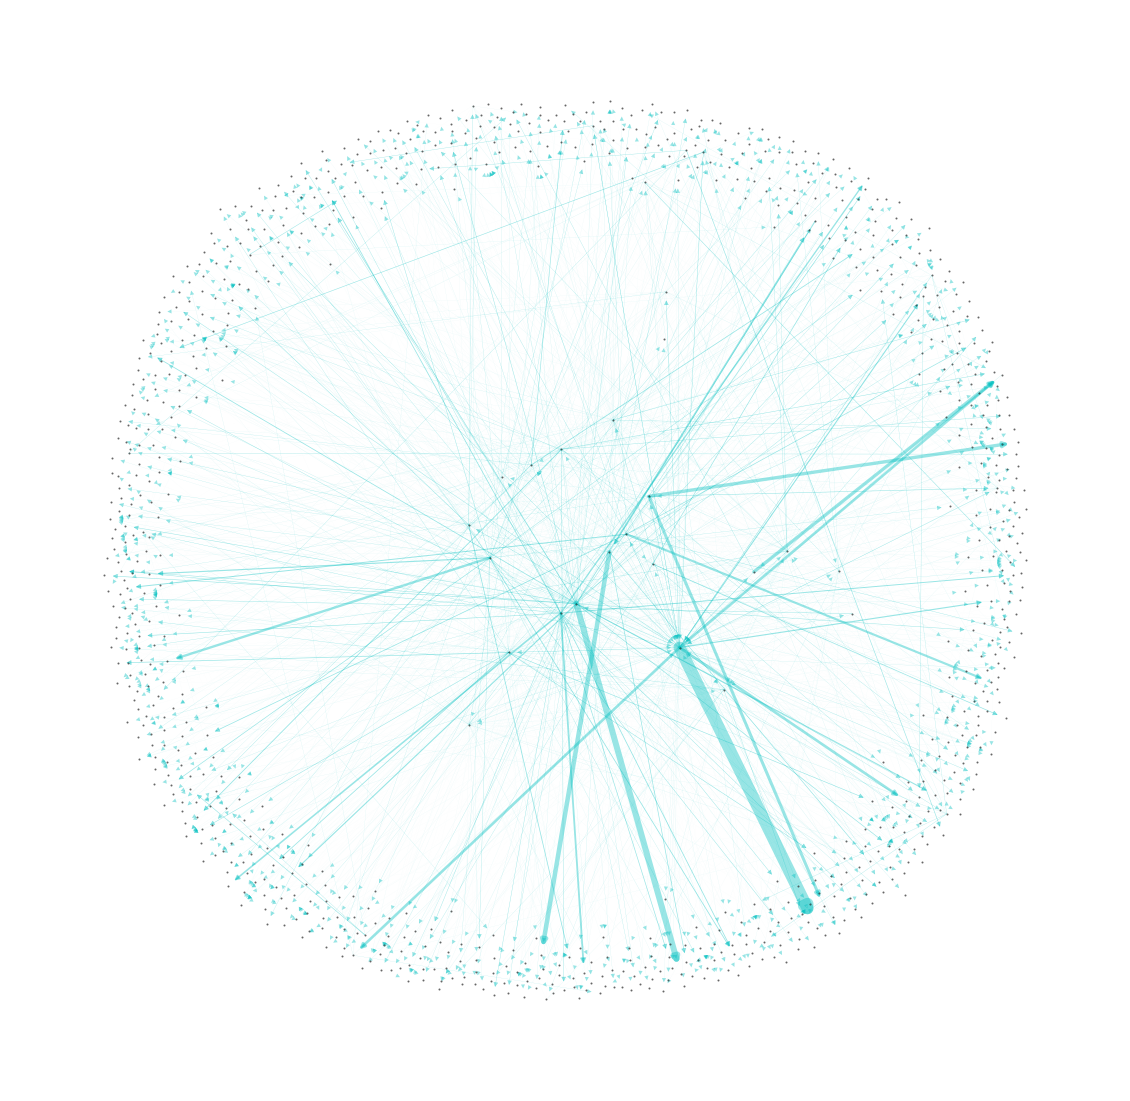

In [10]:
G = nx.DiGraph()
G.add_weighted_edges_from(
    network[network['link_info'] == set(["ハイキュー!!"])][['from_node', 'to_node', 'p']].values)

plt.figure(figsize=(20, 20))
plt.axis('off')
pos = nx.spring_layout(G, k=0.1)
nx.draw_networkx_nodes(G, pos, node_color="w", alpha=0.6, node_size=1, edgecolors="k")
nx.draw_networkx_edges(G, pos, alpha=0.4, edge_color="c", 
                       width=np.array(list(nx.get_edge_attributes(G, 'weight').values()))*100)
plt.show()

## 影響力を推定

情報の伝播は、Independent Cascade Model(独立カスケードモデル)を仮定しています。  
簡単に言うと、あるユーザから情報が伝播するときに(※期待値的に)何人に伝わるかを影響力として、計算しています。  
例えば、友人同士で、ネットワーク上では接続していますが、絶対に情報が伝わるでしょうか？ twitterでフォローしている人のtweetは絶対に見るでしょうか？ これらを確率として、情報の伝播をモデリングしています。(他にも特徴がありますが、ここでは省略します。)
※ 情報が確率的に伝播するとしているため、期待値を計算します。

In [11]:
# from_nodeとto_nodeを数字にラベルエンコードする関数
def name2number(network):
    le = LabelEncoder()
    le.fit(np.unique(network[:, :2]))
    return np.stack([le.transform(network[:, 0]),
                     le.transform(network[:, 1]),
                     network[:, 2]],
                    axis=1), le

In [12]:
net, le = name2number(network_np)

inf = im(net, 1, 200)
inf.run()
result = inf.influence_result()
keys = le.inverse_transform(list(result.keys()))
values = list(result.values())
inf_result = dict(zip(keys, values))


comp init


例えば、以下のユーザは、1.4人に情報を伝えられるユーザです。

In [13]:
inf_result[user]

1.44

## 属性ごとに異なる色を着色

共通のdescription単語ごとに異なる色で枝を描画することを考えます。

In [14]:
G = nx.DiGraph()
link_color_dict = {}
colors = (c for c in plt.cm.get_cmap('tab20').colors)
for u, v ,p, link_info, link_size in network.values:
    if link_size > 0:
        link_info = tuple(link_info)
        color = link_color_dict.get(link_info)
        if not color:
            color = colors.__next__()
            link_color_dict[link_info] = color
        G.add_edge(u, v, weight=p, link=tuple(link_info), color=color)

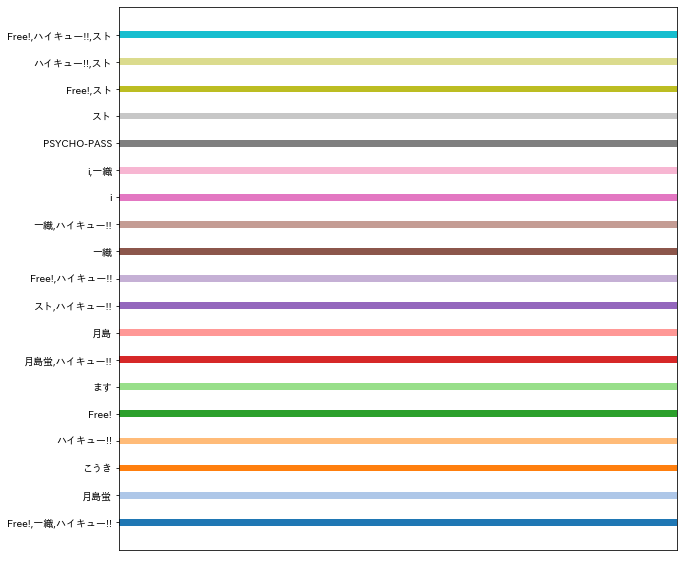

In [15]:
color_list = link_color_dict.values()
tick_label = [','.join(tpl) for tpl in list(link_color_dict.keys())]

plt.figure(figsize=(10, 10))
plt.xticks([])
plt.xlim([0, 1])

x = np.linspace(0, len(color_list)*3, len(color_list))
height = np.repeat(1, len(color_list))
plt.barh(x, height, color=color_list, tick_label=tick_label, align="center")
plt.show()

In [16]:
node_color = ['r' if node == user else 'k' for node in G.nodes()]
node_size = [(inf_result[u]-1)*100 for u in G.nodes()]

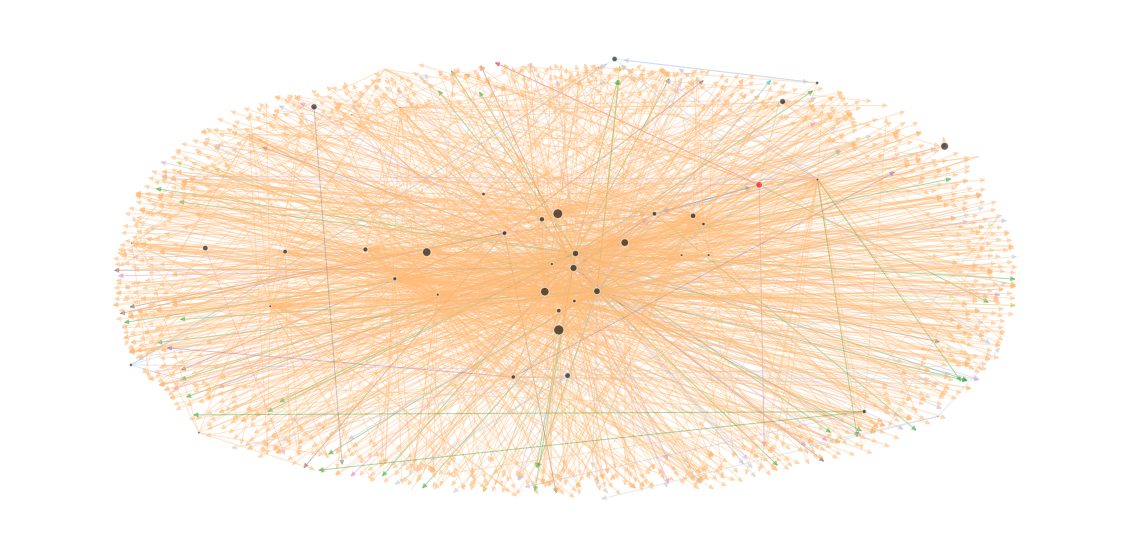

In [17]:
plt.figure(figsize=(20, 10))
plt.axis('off')
pos = nx.spring_layout(G, k=0.1)
nx.draw_networkx_nodes(G, pos, node_color=node_color, alpha=0.6, node_size=node_size, edgecolors='w')
nx.draw_networkx_edges(G, pos, alpha=0.4, edge_color=nx.get_edge_attributes(G, 'color').values(), width=1)
plt.show()

全体的に「ハイキュー!!」を共通単語とする枝が多いことがわかります。

実際に、集計すると以下のようになります。実際に、「ハイキュー!!」が多いことがわかります。

In [18]:
df_count = network.copy()
df_count['link_info'] = network.link_info.apply(lambda x: tuple(x))
df_count.groupby('link_info').count()[['link_size']].reset_index().sort_values('link_size', ascending=False)

,link_info,link_size
0,(),4710
13,"(ハイキュー!!,)",1385
3,"(Free!, ハイキュー!!)",37
1,"(Free!,)",35
11,"(スト,)",33
15,"(一織,)",13
7,"(i,)",11
18,"(月島蛍,)",10
14,"(ハイキュー!!, スト)",8
2,"(Free!, スト)",5


## コミュニティの属性絞り込み

共通のdescription単語が「Free!」である枝のみを残すと以下のようなネットワークになります。

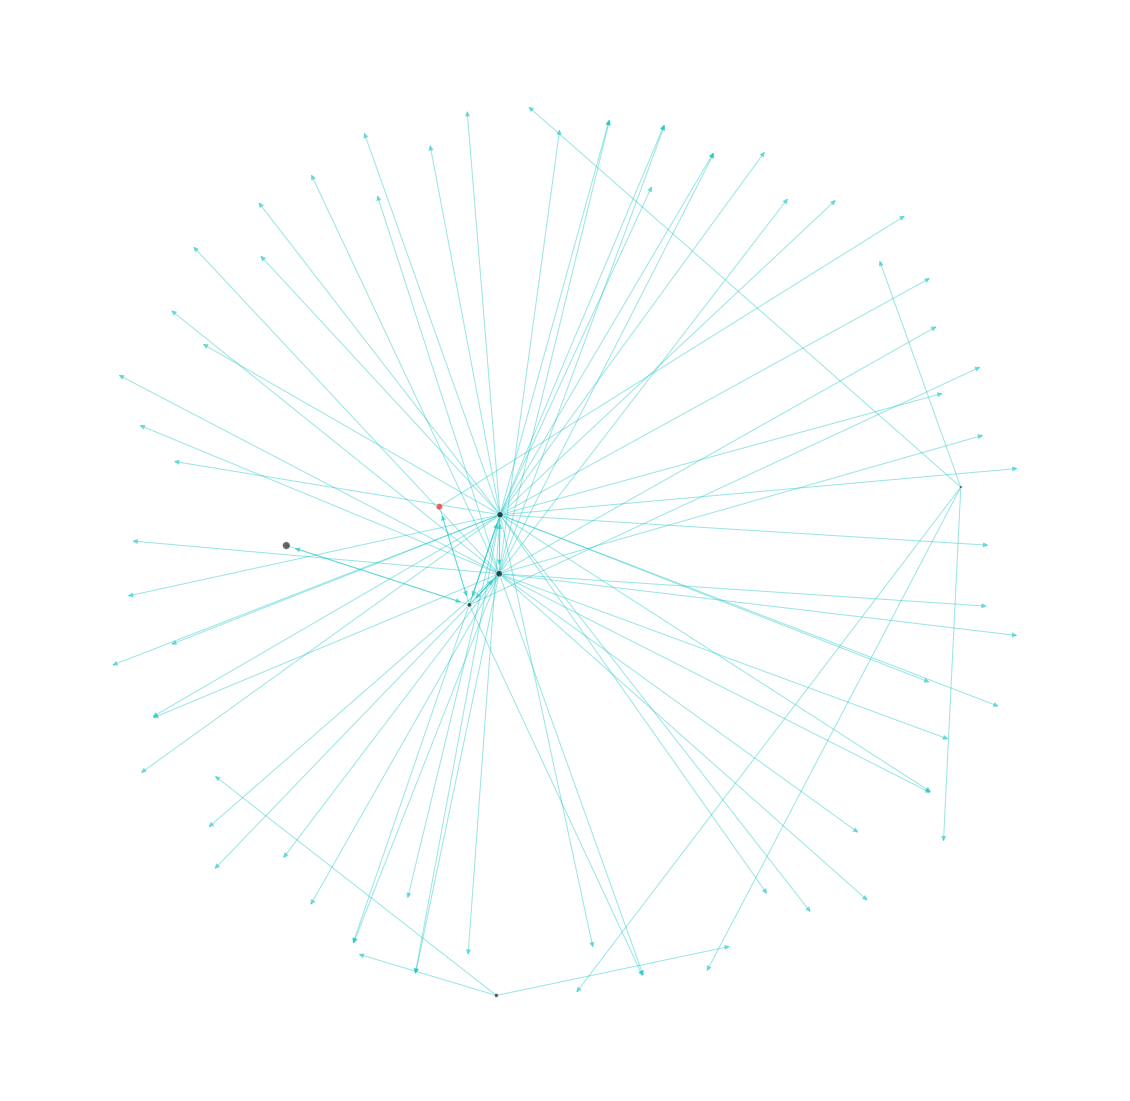

In [19]:
G = nx.DiGraph()

for u, v ,p, link_info, _ in network.values:
    if 'Free!' in link_info:
        link_info = tuple(link_info)
        G.add_edge(u, v, weight=p, link=tuple(link_info))

node_color = ['r' if node == user else 'k' for node in G.nodes()]
node_size = [(inf_result[u]-1)*100 for u in G.nodes()]

plt.figure(figsize=(20, 20))
plt.axis('off')
pos = nx.spring_layout(G, k=0.1)
nx.draw_networkx_nodes(G, pos, node_color=node_color, alpha=0.6, node_size=node_size, edgecolors='w')
nx.draw_networkx_edges(G, pos, alpha=0.4, edge_color='c', width=1)
plt.show()

## 影響力のあるノードのみ残す

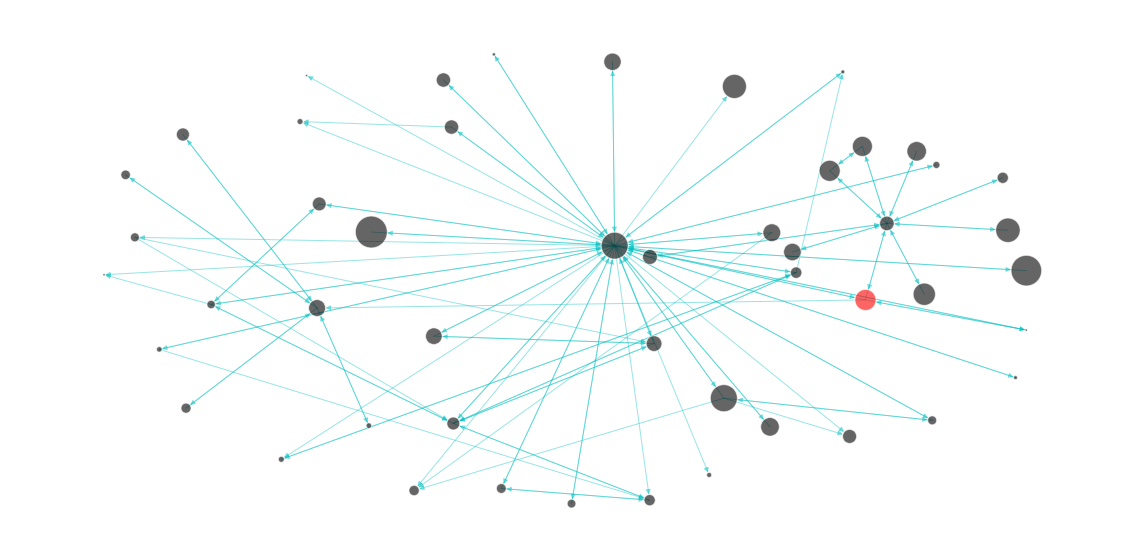

In [20]:
G = nx.DiGraph()

for u, v ,p, link_info, _ in network.values:
    if inf_result[u]-1 > 0 and inf_result[v]-1 > 0:
        link_info = tuple(link_info)
        G.add_edge(u, v, weight=p, link=tuple(link_info))

node_color = ['r' if node=='kotapudding' else 'k' for node in G.nodes()]
node_size = [(inf_result[u]-1)*1000 for u in G.nodes()]

plt.figure(figsize=(20, 10))
plt.axis('off')
pos = nx.spring_layout(G, k=0.1)
nx.draw_networkx_nodes(G, pos, node_color=node_color, alpha=0.6, node_size=node_size, edgecolors='w')
nx.draw_networkx_edges(G, pos, alpha=0.4, edge_color='c', width=1, node_size=node_size)
plt.show()

## 影響力のあるノードのみ残す and 属性ごとに異なる色を着色

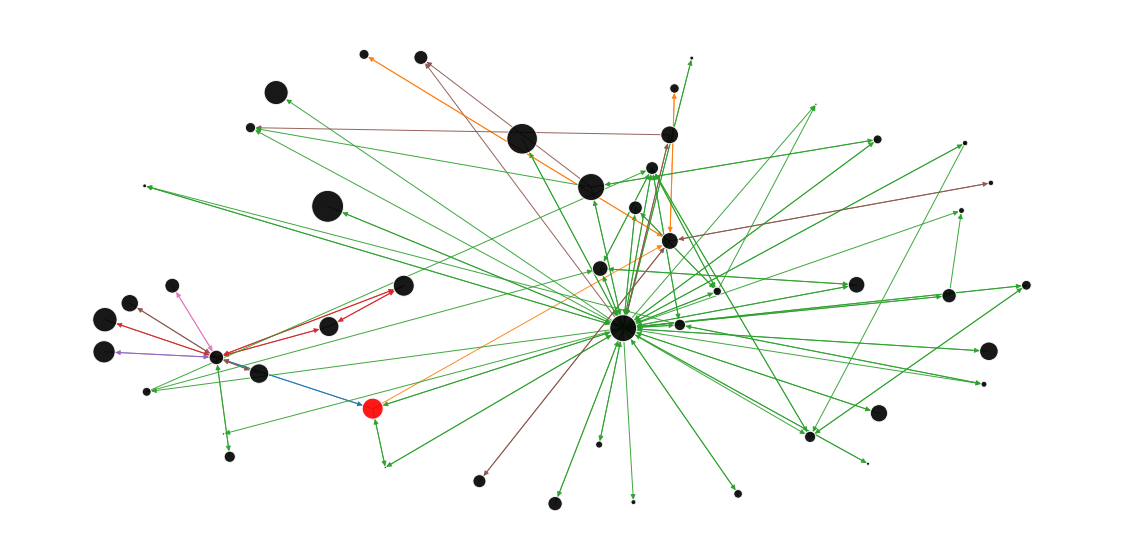

In [21]:
G = nx.DiGraph()
link_color_dict = {}
colors = (c for _, c in mpl.colors.TABLEAU_COLORS.items())

for u, v ,p, link_info, _ in network.values:
    if inf_result[u]-1 > 0 and inf_result[v]-1 > 0:
        link_info = tuple(link_info)
        color = link_color_dict.get(link_info)
        if not color:
            color = colors.__next__()
            link_color_dict[link_info] = color
        G.add_edge(u, v, weight=p, link=link_info, color=color)

node_color = ['r' if node=='kotapudding' else 'k' for node in G.nodes()]
node_size = [(inf_result[u]-1)*1000 for u in G.nodes()]

plt.figure(figsize=(20, 10))
plt.axis('off')
pos = nx.spring_layout(G, k=0.1)
nx.draw_networkx_nodes(G, pos, node_color=node_color, alpha=0.9, node_size=node_size, edgecolors='w')
# nx.draw_networkx_labels(G, pos, font_size=10, font_weight="bold")
nx.draw_networkx_edges(G, pos, alpha=0.9, edge_color=nx.get_edge_attributes(G, 'color').values(), width=1, node_size=node_size)
plt.show()

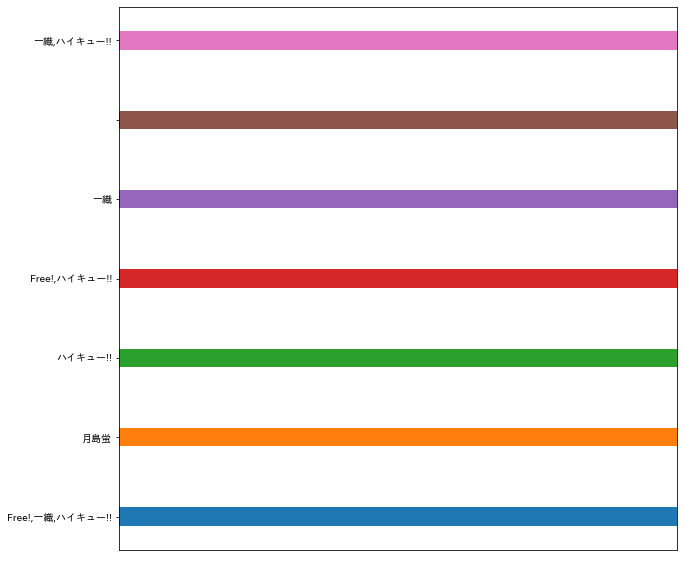

In [22]:
color_list = link_color_dict.values()
tick_label = [','.join(tpl) for tpl in list(link_color_dict.keys())]

plt.figure(figsize=(10, 10))
plt.xticks([])
plt.xlim([0, 1])

x = np.linspace(0, len(color_list)*3, len(color_list))
height = np.repeat(1, len(color_list))
plt.barh(x, height, color=color_list, tick_label=tick_label, align="center")
plt.show()